## This code is to generate a whole tune with given (Xn, Xn+1).
The AI should predict (Xn+2) at first, then use (Xn+2) to predict (Xn+3), use (Xn+3) to predict (Xn+4) and so on...

In [2]:
from IPython.display import display, Image
import IPython.display as ipd
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import tensorflow as tf

from matplotlib import pyplot as plt

# Tomb added
import random
import sys

In [3]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 498


In [4]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [30]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [29]:
"""Tomb made to check if there is a single one, all zeros, or multiple ones in the pitch vector"""

def check_ones_zeros(array):
    count_ones = np.count_nonzero(array == 1)
    count_zeros = np.count_nonzero(array == 0)

    if count_ones == 1 and count_zeros == array.size - 1:
        # print("There is only one '1' and the rest are '0's in the array.")
        return True
    elif count_zeros == array.size:
        # print("All elements in the array are '0's.")
        return True
    else:
        # print("There are either multiple '1's or different values in the array.")
        return False

In [28]:
"""Read_Midi 2"""

def read_midi(filename, sop_alto, seqlen):
  
  def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

  def add_rest_nodes(pianoroll: np.ndarray):  # If all the elemets are zero, the rest node says 1, else 0
        
        restList = []
        for i in pianoroll:
           result = check_ones_zeros(i) # Get boolen either TRUE or False
           if result: # Meaning one "1" and others are zeros or all zeros 
                rests = 1 - np.sum(i)
                # print("rests 1st condi", rests)
                restList.append(rests)
            
            #"There are either multiple '1's or different values in the array."
           else:
                total_sum = np.sum(i)
                rests = total_sum-total_sum # assign int 0 should be avoided as want the code to be dynamic
                # print("rests 2nd condi", rests)
                restList.append(rests)

        # print(type(restList))
        restList = np.array(restList)
        # print(restList.shape)
        restList = np.expand_dims(restList,1)
        # print(restList.shape)
        
        return np.concatenate([pianoroll, restList], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    wholePart_w_rest = add_rest_nodes(wholePart)
    
    return sop_w_rest, alt_w_rest, bass_w_rest, wholePart_w_rest, keymode # All numpy.ndarray including keymode  

In [8]:
"""Make a Window to prepare the model data. 
Make the data(i.e manipulate the model as you tell it what you want) here 
for sequences (Xn, Xn+1) -> Xn+2 and then use Xn+2 to predict Xn+3, 
Xn+3 to predict Xn+4, and so forth"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] # (966240, 2) Total dimesions is 1932480
y_all = [] # (966240, 49) Total dimesions is 47345760
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

raw_seq_length =64

# repeat the process with all the midi files
for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    #make a window to get sequence pairs (Xn, Xn+1) -> Xn+2
    # sop_data, alt_data, bass_data,  keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length) # For Read Midi 1
    sop_data, alt_data, bass_data, whole_part_data, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length) # For Read Midi 2
    desiredData = sop_data
    for i in range(len(desiredData)-3): # range(0, 61)
      # Get (x1,x2) and (x3)vectors  
      input_sequence = desiredData[i:i+2]
      output_target = desiredData[i+2]
      
      x_all.append(input_sequence)
      y_all.append(output_target)
      
      #After obtaining (Xn, Xn+1) -> Xn+2, generate subsequent sequences
    for i in range(len(desiredData)-3):
      subsequent_input = desiredData[i:i+2]
      subsequent_output = desiredData[i+3]

      x_all.append(subsequent_input)
      y_all.append(subsequent_output)

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

# n_notes = len(x_all) # 966240
# print(check_pianoroll_dim(x_all)) 
# print(check_pianoroll_dim(y_all))
# print("Number of files",len(files))
# print("n_notes!",n_notes)

nah
nah
nah


In [20]:
input_data = np.array(x_all) # (60390, 2, 49)
output_data = []

for i in range(len(y_all)): # range(0, 60390)
    output_seq = y_all[i:i + 62]  # output_seq shape(62, 49) Adjust the sequence length as needed
    if len(output_seq) == 62:
        output_data.append(output_seq)

output_data = np.array(output_data)  # shape (60390, 62, 49)

max_index = min(len(input_data), len(output_data)) # 60329
i_train, i_test = train_test_split(range(max_index),test_size=int(max_index/2)) # i_train, i_test len both 30195

x_train = input_data[i_train] # <'numpy.ndarray'> (30195, 2, 49)
x_test = input_data[i_test] # <'numpy.ndarray'> (30195, 2, 49)

y_train = output_data[i_train] # (30165, 62, 49)
y_test = output_data[i_test] # (30164, 62, 49)

# # <<<reshape>>>
# x_train_reshaped = x_train.reshape(-1,2, 49)  # Reshape to sequences of 2 elements
# x_test_reshaped = x_test.reshape(-1, 2, 49)
# # Reshape y_train and y_test to match the output shape
# y_train_reshaped = y_train.reshape(-1, 49)  # Reshape to target for each sequence
# y_test_reshaped = y_test.reshape(-1, 49)

In [21]:
seq_length = x_train.shape[1] #int 2 # How many sequences for input features
pitch_range = x_train.shape[2] # or simply int 49
output_dim = y_train.shape[1] #62

62


In [51]:
# Define the model
model = tf.keras.Sequential()

# Add an LSTM layer
model.add(tf.keras.layers.LSTM(128, input_shape=(2, 49)))  # Adjust units (128) based on your task

# Output layer
model.add(tf.keras.layers.Dense(62 * 49, activation='sigmoid'))  # Adjust output size based on your task

# Reshape the output to match the sequence length and features
model.add(tf.keras.layers.Reshape((62, 49)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
# model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


In [52]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 50
batch_size = 32

model.evaluate(x_train, y_train, return_dict=True)

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test, y_test))

model.evaluate(x_train, y_train, return_dict=True)

943/943 [==============================] - 2s 1ms/step - loss: 0.2500 - accuracy: 0.0232
Epoch 1/50
943/943 [==============================] - 6s 5ms/step - loss: 0.0311 - accuracy: 0.1377 - val_loss: 0.0186 - val_accuracy: 0.1593
Epoch 2/50
943/943 [==============================] - 4s 4ms/step - loss: 0.0184 - accuracy: 0.1786 - val_loss: 0.0183 - val_accuracy: 0.1876
Epoch 3/50
943/943 [==============================] - 4s 5ms/step - loss: 0.0182 - accuracy: 0.1939 - val_loss: 0.0181 - val_accuracy: 0.2035
Epoch 4/50
943/943 [==============================] - 4s 4ms/step - loss: 0.0181 - accuracy: 0.2071 - val_loss: 0.0180 - val_accuracy: 0.2104
Epoch 5/50
943/943 [==============================] - 4s 5ms/step - loss: 0.0180 - accuracy: 0.2109 - val_loss: 0.0180 - val_accuracy: 0.2129
Epoch 6/50
943/943 [==============================] - 4s 4ms/step - loss: 0.0180 - accuracy: 0.2135 - val_loss: 0.0179 - val_accuracy: 0.2153
Epoch 7/50
943/943 [==============================] - 4s 4m

{'loss': 0.017718616873025894, 'accuracy': 0.23442570865154266}

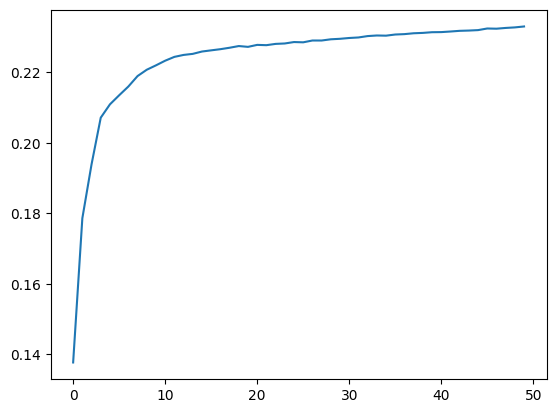

In [53]:
plt.plot(history.epoch, history.history['accuracy'], label='total loss')
plt.show()

In [54]:
y_pred = model.predict(x_test) # y pred shape (30164, 62, 49) <class 'numpy.ndarray'>
print(y_pred.shape)

943/943 [==============================] - 1s 1ms/step
(30164, 62, 49)


In [55]:
"""Renamed as play_midi as the new viersion of the show_play func, 
<show> per se will be worked on later, maybe I want it to be a musical score"""

_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def play_midi(x_test:np.array, y_pred: np.array, filename): #pianorolls shape(1,48)
  
  def make_midi(x_test:np.array, y_pred:np.array, filename): #pianorolls shape (1,48)
      midi = pretty_midi.PrettyMIDI(resolution=480)
      instr = pretty_midi.Instrument(program=1)
      

      for index, test_vector in enumerate(x_test): # done!
        # print("test vec",test_vector)
        for i in range(len(test_vector)): # the test_vector shape is similar to prPred   
            if test_vector[i] > 0.5:
                print("x test idex!!", i)
                instr.notes.append(pretty_midi.Note(start=0.5*index,
                                                        end=0.5*(index+1),
                                                        pitch=36+i,
                                                        velocity=100)) 
      for j in range(len(y_pred)): #range(0, 48)
      # We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
      # 0.5 is only a threshold, coud be any number between 0-1 
      # print("pr i",pianoroll[i])
        if y_pred[j] > 0.5: # check the TS note how it looks like
            print("Got y value!!!!!!!", y_pred[j])
            # print("pianoroll>0.5",pianoroll[i])
            print("y pred index!!",j)
            duration_balance=0.5
            instr.notes.append(pretty_midi.Note(start=(0.5*index)+duration_balance,
                                                end=0.5*(index+1)+duration_balance,
                                                pitch=36+j,
                                            velocity=100)) 
                                         
      midi.instruments.append(instr)
      
      midi.write(f"{filename}.mid")

  
  ##Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(x_test, y_pred, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio(f"{filename}.mid", f"{filename}.wav")

  ipd.display(ipd.Audio(f"{filename}.wav", rate=_SAMPLING_RATE))

In [56]:
k = random.randint(0, len(x_test)) # x_test shape (30195, 2, 49), y_pred (30195, 49)

play_midi(x_test[k], y_pred[k],
"data/output_KP3")

x test idex!! 33
x test idex!! 33


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### --Unused or test code below---